In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [13]:
data = pd.read_csv("data/train.csv")
data.head()
test = pd.read_csv("data/test.csv")

In [14]:
data.shape,test.shape

((1460, 81), (1459, 80))

In [15]:
data.isna().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

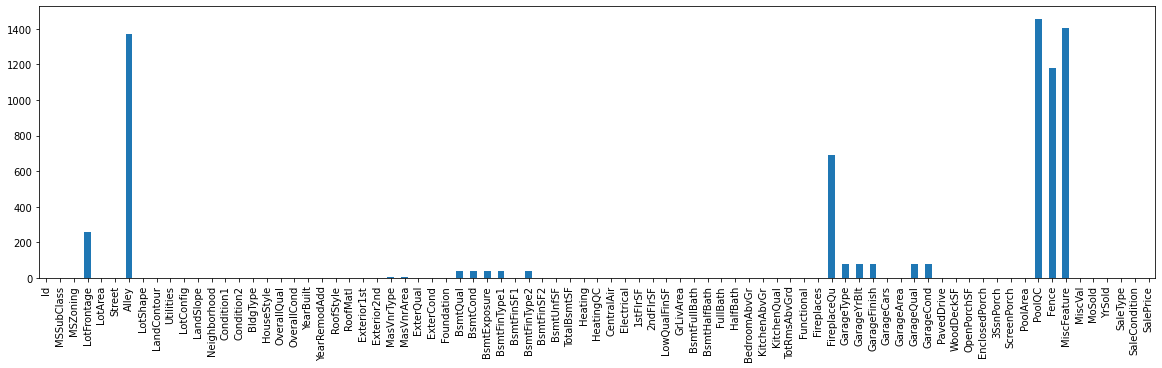

In [16]:
fig , ax1 = plt.subplots(figsize=(20,5))
ax1 = data.isna().sum().plot(kind='bar')

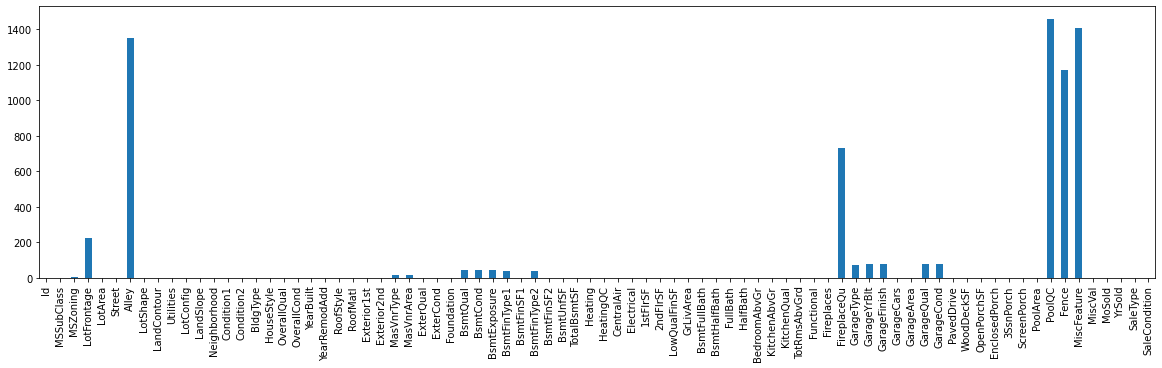

In [17]:
fig , ax1 = plt.subplots(figsize=(20,5))
ax1 = test.isna().sum().plot(kind='bar')

180921.19589041095


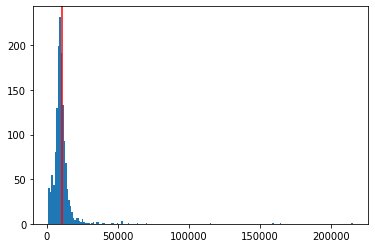

In [18]:
plt.hist(data.LotArea,bins=200);
plt.axvline(data.LotArea.mean(),color='red');
print(data.SalePrice.mean())

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [20]:
# converting object data into pandas categories 
for name, content in data.items():
    if pd.api.types.is_string_dtype(content):
        data[name] = content.astype("category").cat.as_ordered()
for name, content in test.items():
    if pd.api.types.is_string_dtype(content):
        test[name] = content.astype("category").cat.as_ordered()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             1459 non-null   int64   
 1   MSSubClass     1459 non-null   int64   
 2   MSZoning       1455 non-null   category
 3   LotFrontage    1232 non-null   float64 
 4   LotArea        1459 non-null   int64   
 5   Street         1459 non-null   category
 6   Alley          107 non-null    category
 7   LotShape       1459 non-null   category
 8   LandContour    1459 non-null   category
 9   Utilities      1457 non-null   category
 10  LotConfig      1459 non-null   category
 11  LandSlope      1459 non-null   category
 12  Neighborhood   1459 non-null   category
 13  Condition1     1459 non-null   category
 14  Condition2     1459 non-null   category
 15  BldgType       1459 non-null   category
 16  HouseStyle     1459 non-null   category
 17  OverallQual    1459 non-null   in

In [21]:
# Filling the missing data
num=[]
for label, content in data.items():
    if pd.api.types.is_categorical_dtype(content):
        data[label+'_is_missing'] = pd.isnull(content)
        data[label] = pd.Categorical(content).codes + 1
    elif label in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea']:
        data[label+'_is_missing'] = False
    elif pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            data[label+'_is_missing'] = pd.isnull(content)
            data[label] = content.fillna(content.median())
            num.append(label)
            
num_count=[]
for label, content in test.items():
    if pd.api.types.is_categorical_dtype(content):
        test[label+'_is_missing'] = pd.isnull(content)
        test[label] = pd.Categorical(content).codes + 1
    elif pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            test[label+'_is_missing'] = pd.isnull(content)
            test[label] = content.fillna(content.median())
            num_count.append(label)
print(num_count)
print(num)

['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']
['LotFrontage', 'MasVnrArea', 'GarageYrBlt']


In [22]:
extra = []
for name in num_count:
    notin = False
    for already in num:
        if name==already:
            notin = True
    if notin==False:
        extra.append(name)
for name in extra:
    data[name+'_is_missing'] = False 

In [23]:
data.shape,test.shape

((1460, 135), (1459, 134))

In [24]:
# Splitting data into train and validation set
from sklearn.model_selection import train_test_split
X = data.drop('SalePrice',axis=1)
Y = data.SalePrice
x_train,x_val,y_train,y_val = train_test_split(X,Y,test_size=0.2,random_state=42)

In [25]:
# Predicting using baseline model 
from sklearn.ensemble import RandomForestRegressor

baseline = RandomForestRegressor(n_jobs=-1)
baseline.fit(x_train,y_train)

RandomForestRegressor(n_jobs=-1)

In [7]:
# Creating rmsle finction
from sklearn.metrics import mean_squared_log_error
def rmsle(y_true,y_preds):
    return np.sqrt(mean_squared_log_error(y_true,y_preds))

In [27]:
baseline_preds = baseline.predict(x_val)
rmsle(y_val,baseline_preds)

0.15016643602114454

In [9]:
# Finding the best parameters usong GridsearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
model = RandomForestRegressor(n_jobs=-1)
grid = {'n_estimators':[100,200,300,500],
        'min_samples_leaf':[2,3],
        'min_samples_split':[6,8],
        'max_depth':[20,30],
        'max_features':['auto']}
tuned_model = GridSearchCV(estimator=model,
                           param_grid=grid,
                           cv=5,
                           verbose=2)
tuned_model.fit(x_train,y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.4s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.4s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=20

[CV] END max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   0.3s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   0.3s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=   0.4s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=   0.5s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=   0.5s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=   0.6s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=   0.6s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=   0.8s
[CV] END max_depth=20, max_features=auto

[CV] END max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=500; total time=   0.9s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=500; total time=   0.9s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=500; total time=   0.9s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.1s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.1s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.1s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=auto

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1),
             param_grid={'max_depth': [20, 30], 'max_features': ['auto'],
                         'min_samples_leaf': [2, 3],
                         'min_samples_split': [6, 8],
                         'n_estimators': [100, 200, 300, 500]},
             verbose=2)

In [10]:
tuned_model.best_params_

{'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 100}

In [11]:
tuned_model.score(x_val,y_val)

0.8862486604450407

In [28]:
y_preds = tuned_model.predict(x_val)
rmsle(y_val,y_preds)

NameError: name 'tuned_model' is not defined

In [31]:
# Training the tuned model 
from sklearn.ensemble import RandomForestRegressor
from filller import scale
best_model = RandomForestRegressor(n_jobs=-1,
                                   max_depth=30,
                                   min_samples_leaf=2,
                                   min_samples_split=6)
X = scale(X)
best_model.fit(X,Y)

RandomForestRegressor(max_depth=30, min_samples_leaf=2, min_samples_split=6,
                      n_jobs=-1)

In [130]:
data.shape

(1460, 135)

In [134]:
test.shape

(1459, 134)

In [32]:
y_pred = best_model.predict(test)

In [33]:
predictions = pd.DataFrame(y_pred,index=test.Id,columns=['SalePrice'])

In [34]:
predictions.to_csv('predictions2.csv')

In [35]:
import pickle 
pickle.dump(best_model,open('model.pkl','wb'))

In [3]:
from filller import ready_data,scale

In [5]:
X,Y = ready_data("data/train.csv","SalePrice")

Column LotFrontage_is_missing was added to your DataFrame 
Column MasVnrArea_is_missing was added to your DataFrame 
Column GarageYrBlt_is_missing was added to your DataFrame 


In [10]:
X

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,LotFrontage_is_missing,MasVnrArea_is_missing,GarageYrBlt_is_missing
0,-1.730865,0.073375,-0.045532,-0.220875,-0.207142,0.064238,-0.243025,0.750731,0.314667,-0.02618,...,-0.45403,-0.193669,-0.087688,-1.599111,0.138777,0.313867,0.208502,-0.464385,-0.074227,-0.24236
1,-1.728492,-0.872563,-0.045532,0.460320,-0.091886,0.064238,-0.243025,0.750731,0.314667,-0.02618,...,-0.45403,-0.193669,-0.087688,-0.489110,-0.614439,0.313867,0.208502,-0.464385,-0.074227,-0.24236
2,-1.726120,0.073375,-0.045532,-0.084636,0.073480,0.064238,-0.243025,-1.378933,0.314667,-0.02618,...,-0.45403,-0.193669,-0.087688,0.990891,0.138777,0.313867,0.208502,-0.464385,-0.074227,-0.24236
3,-1.723747,0.309859,-0.045532,-0.447940,-0.096897,0.064238,-0.243025,-1.378933,0.314667,-0.02618,...,-0.45403,-0.193669,-0.087688,-1.599111,-1.367655,0.313867,-3.426284,-0.464385,-0.074227,-0.24236
4,-1.721374,0.073375,-0.045532,0.641972,0.375148,0.064238,-0.243025,-1.378933,0.314667,-0.02618,...,-0.45403,-0.193669,-0.087688,2.100892,0.138777,0.313867,0.208502,-0.464385,-0.074227,-0.24236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1.721374,0.073375,-0.045532,-0.357114,-0.260560,0.064238,-0.243025,0.750731,0.314667,-0.02618,...,-0.45403,-0.193669,-0.087688,0.620891,-0.614439,0.313867,0.208502,-0.464385,-0.074227,-0.24236
1456,1.723747,-0.872563,-0.045532,0.687385,0.266407,0.064238,-0.243025,0.750731,0.314667,-0.02618,...,2.46188,-0.193669,-0.087688,-1.599111,1.645210,0.313867,0.208502,-0.464385,-0.074227,-0.24236
1457,1.726120,0.309859,-0.045532,-0.175462,-0.147810,0.064238,-0.243025,0.750731,0.314667,-0.02618,...,0.51794,5.209330,4.953112,-0.489110,1.645210,0.313867,0.208502,-0.464385,-0.074227,-0.24236
1458,1.728492,-0.872563,-0.045532,-0.084636,-0.080160,0.064238,-0.243025,0.750731,0.314667,-0.02618,...,-0.45403,-0.193669,-0.087688,-0.859110,1.645210,0.313867,0.208502,-0.464385,-0.074227,-0.24236


In [6]:
Y.head()

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

In [8]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(X,Y,test_size=0.2,random_state=42)

NameError: name 'X' is not defined

In [46]:
# Training the tuned model 
from sklearn.ensemble import RandomForestRegressor
best_model = RandomForestRegressor(n_jobs=-1,
                                   max_depth=30,
                                   min_samples_leaf=2,
                                   min_samples_split=6)
best_model.fit(X,Y)

RandomForestRegressor(max_depth=30, min_samples_leaf=2, min_samples_split=6,
                      n_jobs=-1)

In [47]:
y_preds = best_model.predict(x_val)
rmsle(y_val,y_preds)

0.0783853568828563

In [2]:
X_test = ready_data("data/test.csv")

NameError: name 'ready_data' is not defined

In [19]:
def ready_dataa(csv_file_path,label=None,num_method="median",time_series=False):
    # Loading the csv file 
    df = pd.read_csv(csv_file_path,low_memory=False)
    # Converting Objects into pandas Category 
    for column ,content in df.items():
        if pd.api.types.is_string_dtype(content):
            df[column] = content.astype("category").cat.as_ordered()
    # Filling the missing values and droping rows with empty label
    for column,content in df.items():
        if pd.api.types.is_categorical_dtype(content):
            df[column] = pd.Categorical(content).codes+1
        elif column in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea']:
            df[column+'_is_missing'] = False
            print(f"Column {column}_is_missing was added to your DataFrame ")
        elif pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df[column+'_is_missing'] = pd.isnull(content)
                print(f"Column {column}_is_missing was added to your DataFrame ")
                if num_method=='median':
                    df[column] = content.fillna(content.median())
                else :
                    df[column] = content.fillna(content.mean())
    # Splitting Dataframe into label and features 
    if label:
        Y = df[label]
        X = df.drop(label,axis=1)
        scaled_df = scale(X)
        return scaled_df,Y
    return scale(df)
X_train,Y_train = ready_dataa("data/train.csv","SalePrice")
X_train.drop("Id",axis=1,inplace=True)

Column LotFrontage_is_missing was added to your DataFrame 
Column MasVnrArea_is_missing was added to your DataFrame 
Column BsmtFinSF1_is_missing was added to your DataFrame 
Column BsmtFinSF2_is_missing was added to your DataFrame 
Column BsmtUnfSF_is_missing was added to your DataFrame 
Column TotalBsmtSF_is_missing was added to your DataFrame 
Column BsmtFullBath_is_missing was added to your DataFrame 
Column BsmtHalfBath_is_missing was added to your DataFrame 
Column GarageYrBlt_is_missing was added to your DataFrame 
Column GarageCars_is_missing was added to your DataFrame 
Column GarageArea_is_missing was added to your DataFrame 


In [20]:
# Training the tuned model 
from sklearn.ensemble import RandomForestRegressor
best_model = RandomForestRegressor(n_jobs=-1,
                                   max_depth=30,
                                   min_samples_leaf=2,
                                   min_samples_split=6)
best_model.fit(X_train,Y_train)

RandomForestRegressor(max_depth=30, min_samples_leaf=2, min_samples_split=6,
                      n_jobs=-1)

In [21]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(X_train,Y_train,test_size=0.2)
y_preds = best_model.predict(x_val)
rmsle(y_val,y_preds)

0.07738845007052388

In [24]:
test = ready_data("data/test.csv").drop("Id",axis=1)

Column LotFrontage_is_missing was added to your DataFrame 
Column MasVnrArea_is_missing was added to your DataFrame 
Column BsmtFinSF1_is_missing was added to your DataFrame 
Column BsmtFinSF2_is_missing was added to your DataFrame 
Column BsmtUnfSF_is_missing was added to your DataFrame 
Column TotalBsmtSF_is_missing was added to your DataFrame 
Column BsmtFullBath_is_missing was added to your DataFrame 
Column BsmtHalfBath_is_missing was added to your DataFrame 
Column GarageYrBlt_is_missing was added to your DataFrame 
Column GarageCars_is_missing was added to your DataFrame 
Column GarageArea_is_missing was added to your DataFrame 


In [25]:
test_preds = best_model.predict(test)
test2 = pd.read_csv("data/test.csv")

In [26]:
predictions = pd.DataFrame(test_preds,index=test2.Id,columns=['SalePrice'])
predictions.to_csv('predictions2.csv')
pred2 = pd.read_csv("predictions2.csv")
pred2

,Id,SalePrice
0,1461,128109.760083
1,1462,157598.626504
2,1463,184888.812482
3,1464,185969.239705
4,1465,195707.329857
...,...,...
1454,2915,85073.221894
1455,2916,87778.541190
1456,2917,152154.291104
1457,2918,114613.543044


In [15]:
pred = pd.read_csv("predictions.csv")
pred

,Id,SalePrice
0,1461,126422.799652
1,1462,154846.793070
2,1463,177705.561216
3,1464,183722.427771
4,1465,203054.838188
...,...,...
1454,2915,84577.565079
1455,2916,84563.109515
1456,2917,154684.920491
1457,2918,112585.903903


In [30]:
test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MasVnrArea_is_missing,BsmtFinSF1_is_missing,BsmtFinSF2_is_missing,BsmtUnfSF_is_missing,TotalBsmtSF_is_missing,BsmtFullBath_is_missing,BsmtHalfBath_is_missing,GarageYrBlt_is_missing,GarageCars_is_missing,GarageArea_is_missing
0,-1.730864,-0.874711,-1.419926,0.567330,0.363929,0.06426,-0.264086,0.742620,0.31870,0.03705,...,-0.101921,-0.026189,-0.026189,-0.026189,-0.026189,-0.03705,-0.03705,-0.237657,-0.026189,-0.026189
1,-1.728490,-0.874711,-0.022037,0.615963,0.897861,0.06426,-0.264086,-1.384637,0.31870,0.03705,...,-0.101921,-0.026189,-0.026189,-0.026189,-0.026189,-0.03705,-0.03705,-0.237657,-0.026189,-0.026189
2,-1.726115,0.061351,-0.022037,0.275532,0.809646,0.06426,-0.264086,-1.384637,0.31870,0.03705,...,-0.101921,-0.026189,-0.026189,-0.026189,-0.026189,-0.03705,-0.03705,-0.237657,-0.026189,-0.026189
3,-1.723741,0.061351,-0.022037,0.470064,0.032064,0.06426,-0.264086,-1.384637,0.31870,0.03705,...,-0.101921,-0.026189,-0.026189,-0.026189,-0.026189,-0.03705,-0.03705,-0.237657,-0.026189,-0.026189
4,-1.721367,1.465443,-0.022037,-1.232092,-0.971808,0.06426,-0.264086,-1.384637,-2.53396,0.03705,...,-0.101921,-0.026189,-0.026189,-0.026189,-0.026189,-0.03705,-0.03705,-0.237657,-0.026189,-0.026189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,1.721367,2.401505,1.375853,-2.302019,-1.591330,0.06426,-0.264086,0.742620,0.31870,0.03705,...,-0.101921,-0.026189,-0.026189,-0.026189,-0.026189,-0.03705,-0.03705,4.207746,-0.026189,-0.026189
1455,1.723741,2.401505,1.375853,-2.302019,-1.599808,0.06426,-0.264086,0.742620,0.31870,0.03705,...,-0.101921,-0.026189,-0.026189,-0.026189,-0.026189,-0.03705,-0.03705,-0.237657,-0.026189,-0.026189
1456,1.726115,-0.874711,-0.022037,4.457971,2.055150,0.06426,-0.264086,0.742620,0.31870,0.03705,...,-0.101921,-0.026189,-0.026189,-0.026189,-0.026189,-0.03705,-0.03705,-0.237657,-0.026189,-0.026189
1457,1.728490,0.646389,-0.022037,-0.308065,0.125527,0.06426,-0.264086,0.742620,0.31870,0.03705,...,-0.101921,-0.026189,-0.026189,-0.026189,-0.026189,-0.03705,-0.03705,4.207746,-0.026189,-0.026189


In [16]:
X_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MasVnrArea_is_missing,BsmtFinSF1_is_missing,BsmtFinSF2_is_missing,BsmtUnfSF_is_missing,TotalBsmtSF_is_missing,BsmtFullBath_is_missing,BsmtHalfBath_is_missing,GarageYrBlt_is_missing,GarageCars_is_missing,GarageArea_is_missing
0,-1.730865,0.073375,-0.045532,-0.220875,-0.207142,0.064238,-0.243025,0.750731,0.314667,-0.02618,...,-0.074227,0.0,0.0,0.0,0.0,0.0,0.0,-0.24236,0.0,0.0
1,-1.728492,-0.872563,-0.045532,0.460320,-0.091886,0.064238,-0.243025,0.750731,0.314667,-0.02618,...,-0.074227,0.0,0.0,0.0,0.0,0.0,0.0,-0.24236,0.0,0.0
2,-1.726120,0.073375,-0.045532,-0.084636,0.073480,0.064238,-0.243025,-1.378933,0.314667,-0.02618,...,-0.074227,0.0,0.0,0.0,0.0,0.0,0.0,-0.24236,0.0,0.0
3,-1.723747,0.309859,-0.045532,-0.447940,-0.096897,0.064238,-0.243025,-1.378933,0.314667,-0.02618,...,-0.074227,0.0,0.0,0.0,0.0,0.0,0.0,-0.24236,0.0,0.0
4,-1.721374,0.073375,-0.045532,0.641972,0.375148,0.064238,-0.243025,-1.378933,0.314667,-0.02618,...,-0.074227,0.0,0.0,0.0,0.0,0.0,0.0,-0.24236,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1.721374,0.073375,-0.045532,-0.357114,-0.260560,0.064238,-0.243025,0.750731,0.314667,-0.02618,...,-0.074227,0.0,0.0,0.0,0.0,0.0,0.0,-0.24236,0.0,0.0
1456,1.723747,-0.872563,-0.045532,0.687385,0.266407,0.064238,-0.243025,0.750731,0.314667,-0.02618,...,-0.074227,0.0,0.0,0.0,0.0,0.0,0.0,-0.24236,0.0,0.0
1457,1.726120,0.309859,-0.045532,-0.175462,-0.147810,0.064238,-0.243025,0.750731,0.314667,-0.02618,...,-0.074227,0.0,0.0,0.0,0.0,0.0,0.0,-0.24236,0.0,0.0
1458,1.728492,-0.872563,-0.045532,-0.084636,-0.080160,0.064238,-0.243025,0.750731,0.314667,-0.02618,...,-0.074227,0.0,0.0,0.0,0.0,0.0,0.0,-0.24236,0.0,0.0
